In [1]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

IMG_PATH = 'medium.png'

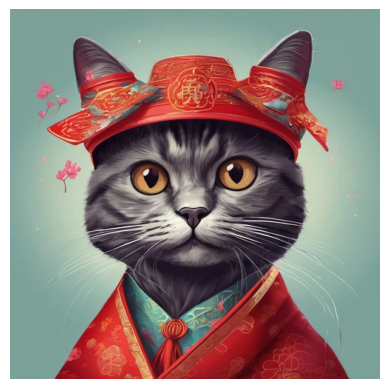

In [2]:
img = cv2.imread(IMG_PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis("off")
plt.show()

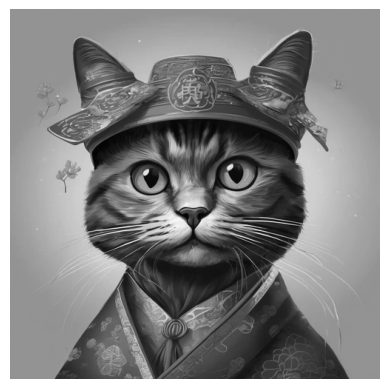

In [3]:
img = cv2.imread(IMG_PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()

In [4]:
img = np.expand_dims(img, axis=(0, 1))
img

array([[[[150, 150, 150, ..., 150, 150, 150],
         [150, 150, 150, ..., 150, 150, 150],
         [150, 150, 150, ..., 150, 150, 150],
         ...,
         [148, 148, 148, ..., 149, 149, 149],
         [148, 148, 148, ..., 149, 149, 149],
         [148, 148, 148, ..., 149, 149, 149]]]], dtype=uint8)

In [5]:
def split_image(image: np.ndarray):
    """
    Splits a 2H x 2W grayscale image into two H x W images:
    - `odd_image`: pixels from odd rows and odd columns.
    - `even_image`: pixels from even rows and even columns.
    
    :param image: np.ndarray of shape (2H, 2W)
    :return: (even_image, odd_image) each of shape (H, W)
    """
    if len(image.shape) != 4:
        raise ValueError("Input image must be a 2D grayscale array")
    
    even_image = image[:, :, 0::2, 0::2]
    odd_image = image[:, :, 1::2, 1::2]
    
    return even_image, odd_image

e_img, o_img = split_image(img)

In [6]:
print("img shape (HxW):", img.shape)
print("even img shape:\t", e_img.shape)
print("odd img shape:\t", o_img.shape)

img shape (HxW): (1, 1, 500, 500)
even img shape:	 (1, 1, 250, 250)
odd img shape:	 (1, 1, 250, 250)


In [7]:
class CNN(torch.nn.Module):
    def __init__(self):
        super().__init__()

        channel = 32
        layers = [torch.nn.Conv2d(1, channel, 3, 1, 1)]
        layers.append(torch.nn.LeakyReLU(inplace=True))
        layers.append(torch.nn.Conv2d(channel, channel, 3, 1, 1))
        self.conv1 = torch.nn.Sequential(*layers)

        layers = [torch.nn.Conv2d(1, channel, 5, 1, 2)]
        layers.append(torch.nn.LeakyReLU(inplace=True))
        layers.append(torch.nn.Conv2d(channel, channel, 3, 1, 1))
        self.conv2 = torch.nn.Sequential(*layers)

        layers = [torch.nn.Conv2d(1, channel, 7, 1, 3)]
        layers.append(torch.nn.LeakyReLU(inplace=True))
        layers.append(torch.nn.Conv2d(channel, channel, 3, 1, 1))
        self.conv3 = torch.nn.Sequential(*layers)

        layers = [torch.nn.Conv2d(channel, channel, 3, 1, 1)]
        layers.append(torch.nn.LeakyReLU(inplace=True))
        layers.append(torch.nn.Conv2d(channel, channel, 3, 1, 1))
        self.conv4 = torch.nn.Sequential(*layers)

        layers = [torch.nn.Conv2d(channel, channel, 3, 1, 1)]
        layers.append(torch.nn.LeakyReLU(inplace=True))
        layers.append(torch.nn.Conv2d(channel, 1, 3, 1, 1))
        self.conv5 = torch.nn.Sequential(*layers)

    def forward(self, images, images_=None):
        out1 = self.conv1(images)
        out2 = self.conv2(images)
        out3 = self.conv3(images)
        out4 = self.conv4(out1 + out2 + out3)

        out = self.conv5(out1 + out2 + out3 + out4)

        loss = None
        if images_ is not None:
            loss = torch.nn.functional.mse_loss(out, images_)

        return out, loss

model = CNN()

In [8]:
e_img = torch.tensor(e_img, dtype=torch.float32)
o_img = torch.tensor(o_img, dtype=torch.float32)

In [9]:
img_, loss = model(e_img, o_img)
print("Output shape:", img_.shape)
print("Loss:", loss)

Output shape: torch.Size([1, 1, 250, 250])
Loss: tensor(16220.7764, grad_fn=<MseLossBackward0>)


In [10]:
img_, loss = model(o_img, e_img)
print("Output shape:", img_.shape)
print("Loss:", loss)

Output shape: torch.Size([1, 1, 250, 250])
Loss: tensor(16283.1943, grad_fn=<MseLossBackward0>)
